<font size="5">**Maximize Your US National Parks Pass**</font>
<br>
*by : Chris at Savvy Analytics*

<span style="color:blue"><font size="3">Background : </font></span>
Recently a my daughter bought a National Parks pass.  This is quite a value, allowing her and guests to visit any park in the US for \\$80/year versus the normal \\$25/day.

<span style="color:blue"><font size="3">Challenge : </font></span>
Imagine that you were able to work remotely and therefore live about anywhere.  Where would you locate yourself so that you could enjoy the most parks during a weekend trip?

In [1]:
import pandas as pd
import requests
from io import StringIO
from bs4 import BeautifulSoup
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
#import re

Next, some information about the National Parks is needed and conveniently, Wikipedia has what is needed.  The beautiful soup library can extract the relevant data.

In [2]:
# Load the National Parks URL and create a list of the tables
np_url = "https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States"
response = requests.get(np_url, verify=False)
soup = BeautifulSoup(response.content, 'html.parser'
tables = soup.find_all('table')

C:\Users\Chris.Woolery\AppData\Local\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [3]:
# Isolate the 2nd list which has the National Parks data frame and
# Use Regex and string manipulation to clean up the data 
html_content = str(tables[1])
nationalparks = pd.read_html(StringIO(html_content), header=0)[0]
nationalparks = nationalparks.rename(columns={
    nationalparks.columns[3]: "DateEstablished",
    nationalparks.columns[4]: "AreaAcres",
    nationalparks.columns[5]: "AnnualVisitors"
})


In [4]:
nationalparks["State"] = nationalparks["Location"].str.extract(r'^([\D]+)')
nationalparks = nationalparks.assign(State = nationalparks['State'].str.strip())
nationalparks["Lat"] = nationalparks["Location"].str.extract(r'(\d+\.\d+)')
nationalparks["Lat"] = pd.to_numeric(nationalparks["Lat"])
nationalparks["Long"] = nationalparks["Location"].str.extract(r'(\d*.\d*(?=.W$))')
nationalparks["Long"] = pd.to_numeric(nationalparks["Long"]) * -1
nationalparks["AreaAcres"] = nationalparks["AreaAcres"].str.replace(",", "")
nationalparks["AreaAcres"] = nationalparks["AreaAcres"].str.extract(r'(^\d*.\d*)')
nationalparks["AreaAcres"] = pd.to_numeric(nationalparks["AreaAcres"])
nationalparks["DateEstablished"] = nationalparks["DateEstablished"].str.replace(r'\[\d+\]', '', regex=True)
nationalparks["DateEstablished"] = pd.to_datetime(nationalparks["DateEstablished"], format="%B %d, %Y")
nationalparks = nationalparks[["Name", "State", "Lat", "Long", "DateEstablished", "AreaAcres", "AnnualVisitors"]]
# Let's reduce the data set to only include the lower 48 states since our goal will be to make weekend drives which are hard to do to Islands or in Alaska during the winter
lower48parks = nationalparks.copy() #Pandas throws a warning if you attempt to filter nationalparks directly into l48
lower48parks = lower48parks[~lower48parks["State"].isin(["Hawaii", "Alaska", "American Samoa", "U.S. Virgin Islands", "Puerto Rico"])]
lower48parks["Initial"] = lower48parks["Name"].str[:1]

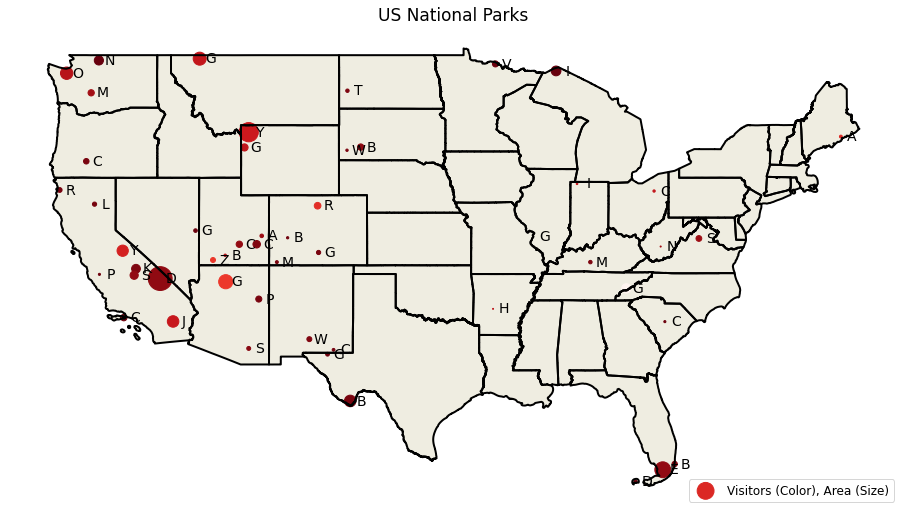

In [5]:
#From : https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=States+%28and+equivalent%29
usafile = "C:/Users/Chris.Woolery/.Shapefiles/tl_2020_us_state.shp"
usa = gpd.read_file(usafile)
usa = usa[~usa["STUSPS"].isin(['HI','VI','MP','GU','AK','AS','PR'])]

fig, ax = plt.subplots(figsize=(16, 16))
#usa.boundary.plot(ax=ax, color='#000000')
usa.plot(ax=ax, color='#efede1')
usa.boundary.plot(ax=ax, color='black', linewidth = 2)

lower48parks_scatter = ax.scatter(lower48parks['Long'], lower48parks['Lat'], c=lower48parks['AnnualVisitors'], 
           s=lower48parks['AreaAcres'] / 6000, cmap='Reds_r')

#ax.text(lower48parks['Long'] + 0.8, lower48parks['Lat'], lower48parks['Initial'], size=4)
for idx, row in lower48parks.iterrows():
    lower48parks_text = plt.text(row['Long']  + 0.8, row['Lat'], row['Initial'], ha='center', va='center', 
                                 fontsize = 14, color = "black")

ax.set_title('US National Parks', fontsize = 17, color = 'black')

plt.legend([lower48parks_scatter], ['Visitors (Color), Area (Size)'], loc='lower right', fontsize = 12) # display legend
#plt.legend([lower48parks_text], ['Visitors'], loc='upper right') # display legend

plt.axis('off')
plt.show()

Note : Need to fix the legend and Michigan as well as sub-title

In [6]:
displaydf = lower48parks.drop("Initial", axis = 'columns')
#display(HTML("<div style='max-height: 400px'>" + displaydf.to_html() + "</div>"))
display(HTML("<div style='max-height: 400px'>" + displaydf.style.hide(axis="index").to_html() + "</div>"))

```{r fig.height=8, fig.width=12}
usa <- borders("state", fill = "#efede1")

ggplot() + usa +
  geom_point(data = lower48parks, 
             aes(x = Long, y = Lat, color = AnnualVisitors, size = AreaAcres)) +
  scale_color_gradient(low = "grey", high = "dark red") +
  geom_text(data = lower48parks,
            aes(x = Long, y = Lat, label = Initial), size = 4, nudge_x = .8) +
  theme_void() +
  labs(title = "US National Parks", 
       subtitle = "Lower 48 - Park Locations",
       color = "Annual Visitors",
       size = "Area in Acres")

```
```{r echo=FALSE, fig.height=15, fig.width=10}

require(DT)

lower48parks %>%
  dplyr::select(-Initial) %>%
  datatable()

```